## Step 1: Create DataFrame
- The CSV file containing the cleaned data is imported, setting the ZIP column to string to prevent truncation of the data
- A pivot table is created with the ZIP codes as the table index, columns of Month numbers (1-12), values of the Average Heat Index, and an aggregate function to handle duplicate ZIP codes that span multiple states.
- Finally, the Average Heat Indices are rounded to 2 decimal places

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('ten_year_avg_2008_2017.csv',
                 dtype={'ZIP':str}
                )

table = pd.pivot_table(
    df, 
    index='ZIP', 
    columns='Month', 
    values='Avg.HeatIndex.Mean', 
    aggfunc='mean')

table = table.round(2)

In [7]:
from sklearn.cluster import KMeans

## Step 2: KMeans Machine Learning Algorithm Applied
- The final value of k = 10.  Experimentation was done and k = 10 was found to provide the best cluster structure for the project needs.
- KMeans is called, assigning the clusters to k and randomizing the start state to 42
- A second pivot table called features is created to drop any existing clusters column, because any retained cluster data from previous runs would cause error in KMeans due to multiple instances of numeric data.  The column headers are also converted to string data types for the same reason, ensuring the only remaining numeric data is the Heat Index values.
- Kmeans is then trained using the features table.
- After training, the assigned clusters are written to the original table under a new cluster column.

In [35]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
features = table.drop(columns='cluster', errors='ignore')
features.columns = features.columns.astype(str)
kmeans.fit(features)
table['cluster'] = kmeans.labels_

## Step 3: Cluster Numbers Merged with Original Dataset
- A new data frame called table_zip_column is created, using the data from table, but instead of using ZIP as the index, using row numbers.
- The final dataset is created by left joining table_zip_column with the original data frame (df) on ZIP, creating the data frame df_clusters.
- The final dataset is written to a CSV file for later use.

In [36]:
table_zip_column=table.reset_index() 
df_clusters = df.merge(table_zip_column[['ZIP', 'cluster']], on='ZIP', how='left')
df_clusters.to_csv('clustered_ZIP_climates.csv', index=False)

## Exploratory: Cluster Value Count
- This outputs the count of each cluster, allowing for evaluating the relative spread of the clusters.

In [37]:
table['cluster'].value_counts().sort_index()

cluster
0     525
1    1798
2     320
3    2313
4    1135
5     951
6    1236
7     251
8    1125
9     263
Name: count, dtype: int64

## Exploratory: Average Monthly Cluster Values
- The average of each month is calculated per cluster.  This allows for quick comparison of the clusters and the spread of the data within each cluster.

In [38]:
cluster_profiles = table.groupby('cluster').mean(numeric_only=True)
cluster_profiles

Month,1,2,3,4,5,6,7,8,9,10,11,12
cluster,,,,,,,,,,,,
0,59.384590,62.029543,66.632038,73.500076,79.404590,85.457352,87.554743,88.688610,84.907733,76.445162,67.712876,64.104895
1,30.175768,32.279939,40.138509,50.744071,61.105056,70.917653,76.700495,73.899477,67.111418,54.544566,43.486563,35.987881
2,46.438625,49.542531,54.181594,58.112531,64.571687,72.589687,77.243969,76.591000,73.199188,63.531562,53.063875,45.798250
3,24.919520,27.255767,36.311565,46.239001,57.345110,67.603005,73.545482,71.098150,63.559784,50.636213,39.753878,30.028353
4,32.720802,35.531286,44.320978,55.224361,65.006247,75.998273,80.854458,77.401965,69.900758,56.869066,45.263004,37.647577
5,52.648433,53.729674,56.619211,58.855247,61.840652,66.160515,69.764080,70.648307,70.436446,65.322440,58.133218,51.881956
6,49.075235,53.390793,60.823754,68.369757,76.005890,86.120235,89.385696,89.046950,81.894984,70.327500,59.106068,51.104223
7,67.301793,69.315936,71.747490,77.334861,81.922072,87.664502,90.160637,91.269004,88.407092,82.149522,74.310996,71.479124
8,39.993351,43.419591,51.768898,61.310969,69.561671,80.124907,83.353956,81.276987,73.828098,61.346293,49.938382,43.762916


## Exploratory: MSA to Clusters Count
- The dataset is grouped by MSA (metropolitan area) and cluster, counting how many times each an MSA-associated ZIP appears in each cluster (0-9)

In [41]:
msa_cluster_counts = df_clusters.groupby(['MSA', 'cluster'])['ZIP'].nunique().unstack(fill_value=0)

## Exploratory: Output All MSA to Clusters Count
- The pandas display options are set to max to ensure all 120 rows of the MSA to Clusters Count are displayed.
- The data is displayed.

In [42]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
msa_cluster_counts.to_csv('msa cluster counts.csv', index=True)
msa_cluster_counts

cluster,0,1,2,3,4,5,6,7,8,9
MSA,,,,,,,,,,
10420,0,0,0,42,0,0,0,0,0,0
10580,0,0,0,62,0,0,0,0,0,0
10740,0,42,0,0,4,0,0,0,0,0
10900,0,57,0,4,0,0,0,0,0,0
11244,0,0,0,0,0,132,0,0,0,0
12060,0,0,0,0,0,0,0,0,215,0
12260,0,0,0,0,0,0,0,0,26,0
12420,0,0,0,0,0,0,85,0,0,0
12540,0,0,21,0,0,0,0,0,0,0


### Clusters per MSA

In [43]:
clusters_per_msa = (msa_cluster_counts > 0).sum(axis=1)
msa_distribution = clusters_per_msa.value_counts().sort_index()
dist_df = msa_distribution.reset_index()
dist_df.columns = ["num_clusters", "num_MSAs"]
print(dist_df)

   num_clusters  num_MSAs
0             1        89
1             2        30
2             4         1


## Exploratory: Davies Bouldin Index (DBI) and Silhouette
- The DBI scores help to evaluate the relative compactness and regularity of each cluster.  Scores < 1 are considered valid, with closer to 0 showing increasing compactness and regularity.
- The Silhouette scores help to determine the distance between each point and its own cluster as well as neighboring clusters.
- A second pivot table called features is created to drop any existing clusters column, because any retained cluster data from previous runs would cause error in KMeans due to multiple instances of numeric data.  The column headers are also converted to string data types for the same reason, ensuring the only remaining numeric data is the Heat Index values.
- An empty list is created to hold the DBI and Silhouette scores.
- A for loop runs the KMeans algorithm for k values in the range (2, 16).
- The score for each k value is written to the scores list, and then the list is written to a dataframe, scores_df.
- The results are printed.

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

features = table.drop(columns='cluster', errors='ignore')
features.columns = features.columns.astype(str)

scores = []
for k in range(2, 16):
    X = features
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    dbi = davies_bouldin_score(X, labels)
    sil = silhouette_score(X, labels)
    scores.append({'k': k, 'DBI Score': round(dbi, 4), 'Silhouette Score': round(sil, 4)})
score_df = pd.DataFrame(scores)
score_df



,k,DBI Score,Silhouette Score
0,2,0.6714,0.5581
1,3,0.7453,0.5361
2,4,0.6416,0.5301
3,5,0.7207,0.4746
4,6,0.6828,0.4759
5,7,0.7129,0.4989
6,8,0.7081,0.4269
7,9,0.8203,0.4030
8,10,0.7200,0.4341
9,11,0.7080,0.4514


## Visualizations

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ks = score_df['k'].tolist()
sil_scores = score_df['Silhouette Score'].tolist()
dbi_scores = score_df['DBI Score'].tolist()

### Silhouette Score vs. Number of Clusters

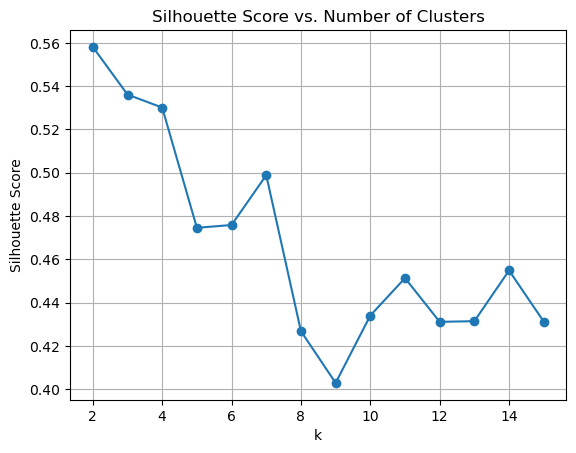

In [16]:
plt.figure()
plt.plot(ks, sil_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### Davies-Bouldin Index Plot

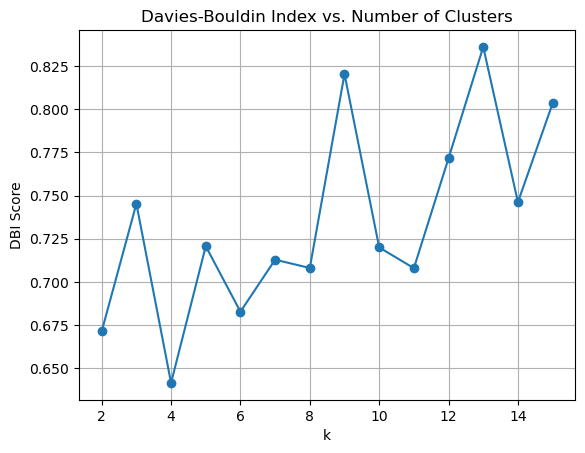

In [17]:
plt.figure()
plt.plot(ks, dbi_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('k')
plt.ylabel('DBI Score')
plt.grid(True)
plt.show()

### Cluster-Center Profiles

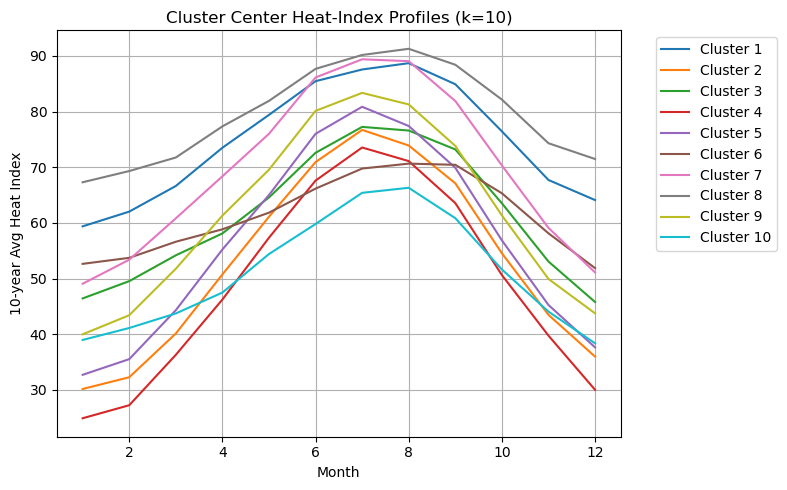

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

features = table.drop(columns='cluster', errors='ignore')
features.columns = features.columns.astype(str)

k = 10
kmeans = KMeans(n_clusters=k, random_state=42).fit(features) 

centers = kmeans.cluster_centers_
months = list(range(1,13))

plt.figure(figsize=(8, 5))
for i, center in enumerate(centers, start=1):
    plt.plot(months, center, label=f'Cluster {i}')

plt.title('Cluster Center Heat-Index Profiles (k=10)')
plt.xlabel('Month')
plt.ylabel('10-year Avg Heat Index')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

### Distribution of Heat Indices by Cluster

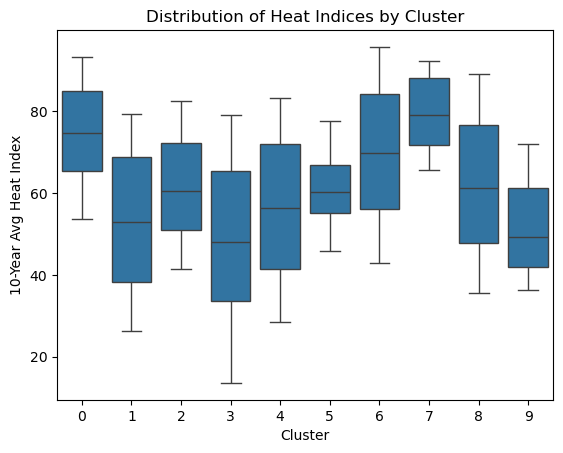

In [19]:
plt.figure()
sns.boxplot(x='cluster', y='Avg.HeatIndex.Mean', data=df_clusters)
plt.title('Distribution of Heat Indices by Cluster')
plt.xlabel('Cluster')
plt.ylabel('10-Year Avg Heat Index')
plt.show()

### Summary Statistics Table

In [20]:
summary = (
    df_clusters
    .groupby('cluster')['Avg.HeatIndex.Mean']
    .agg(['mean', 'min', 'max', 'std'])
    .round(2)
    .reset_index()
    .rename(columns={
        'mean': 'Mean',
        'min': 'Min', 
        'max': 'Max',
        'std': 'StdDev'
    })
)
print(summary)

   cluster   Mean    Min    Max  StdDev
0        0  74.65  53.58  93.36   10.21
1        1  53.21  26.19  79.29   16.12
2        2  61.24  41.42  82.50   11.46
3        3  48.94  13.61  79.06   17.17
4        4  56.44  28.49  83.30   16.65
5        5  61.34  45.79  77.70    7.20
6        6  69.55  42.88  95.74   14.54
7        7  79.42  65.68  92.33    8.28
8        8  61.55  35.69  89.02   15.32
9        9  51.37  36.25  72.00   10.05


### Line Plot of Monthly Averages

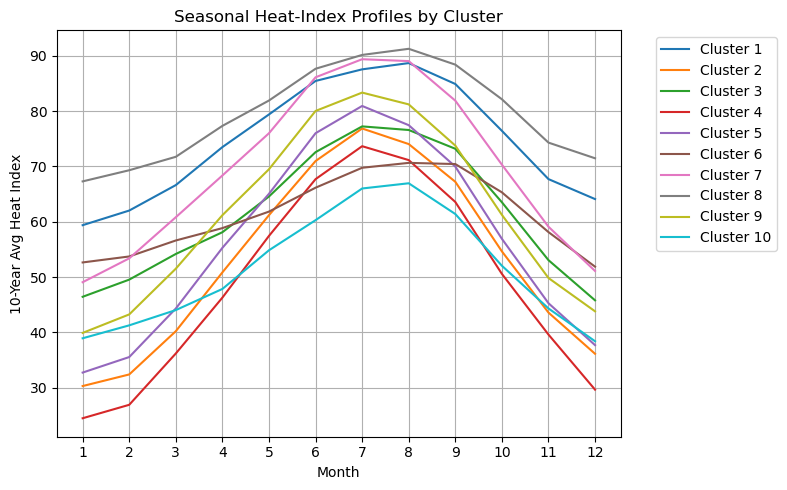

In [21]:
monthly=(
    df_clusters
    .groupby(['cluster', 'Month'])['Avg.HeatIndex.Mean']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
for cid, group in monthly.groupby('cluster'):
    plt.plot(group['Month'], group['Avg.HeatIndex.Mean'], label=f'Cluster {cid+1}')
plt.title('Seasonal Heat-Index Profiles by Cluster')
plt.xlabel('Month')
plt.ylabel('10-Year Avg Heat Index')
plt.xticks(range(1,13))
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()